In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("kit_hist")

# from utils.models.interaction_network import InteractionNetwork
from utils.hls4ml.load_torch import load_graphs, load_models
from utils.plotting.plot_events import plot_information, plot_event
from utils.hls4ml.compare import compare_hls4ml

# Load graph data (100 events)
Truncate node and edge size at 95% of sizes of all events

In [2]:
graph_indir = 'data/3_segments'
output_dir = 'hls_output/simulation/test'
nevents = 100

graph_dims = {
    "n_node": 28,
    "n_edge": 56,
    "node_dim": 3,
    "edge_dim": 3
}

graphs = load_graphs(graph_indir, output_dir, graph_dims, nevents)

n_graphs: 38
node dimension: torch.Size([28, 3]), edge dimension: torch.Size([56, 3])
36.0% of graphs without truncation of nodes
65.0% of graphs without truncation of edges
writing test bench data for 1st graph to hls_output/simulation/test/tb_data/input_data.dat


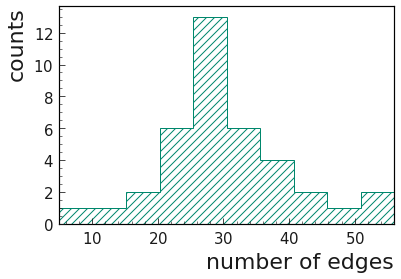

In [3]:
n_nodes, n_edges = [],[]
for g in graphs:
    n_nodes.append(len(g.x))
    n_edges.append(len(g.target))
plt.hist(n_edges, histtype='stepfilled', facecolor=(0,0,0,0))
plt.xlabel('number of edges')
plt.ylabel('counts')
plt.show()


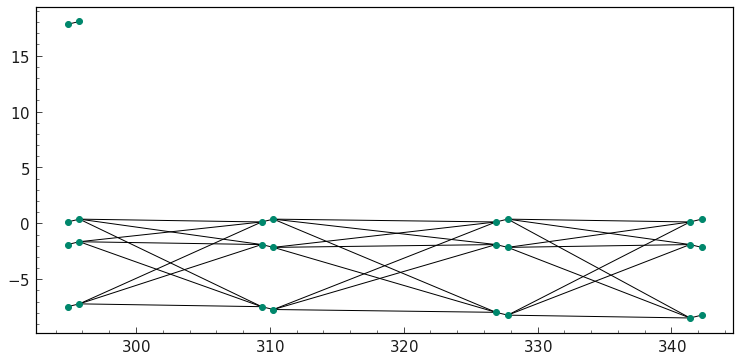

In [5]:
import matplotlib.pyplot as plt
plt.style.use('kit')


evID = np.random.randint(38)
data = graphs[evID]
X = data.x[~np.all(np.array(data.x ==0), axis=1)]
segments = data.edge_index.T[~np.all(np.array(data.edge_index.T==data.edge_index.max()), axis=1)]

plt.figure(figsize=(12.5,6))

for ids in segments:
    id1, id2 = ids
    x,z,theta = np.vstack((X[int(id1)], X[int(id2)])).T
             
    plt.plot(z*100, x*10, linewidth=1.0, linestyle='-', marker='None', color='black') 


x,z,_ = X.T
plt.plot(z*100, x*10, linestyle='None')
plt.show()

# Load model and compile hls model

In [6]:
nevents = 100
trained_model_dir = f'models/IN_trained_segments_3_events_500_neurons_6_state_dict.pt'
precision = 'ap_fixed<16,8>'
index_precision = 'ap_uint<8>'
reuse = 1
part = 'xczu9eg-ffvb1156-2-e'
n_neurons=6

torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,graph_dims, hls_only=False)
torch_model.count_parameters()
hls_model.compile()

print("Model compiled at: ", hls_model.config.get_output_dir())
model_config = f"precision: {precision} \nreuse_factor: {reuse}"
with open(hls_model.config.get_output_dir() + "//model_config.txt", "w") as file:
    file.write(model_config)

InteractionNetwork(node_dim: 3, edge_dim: 3, hidden_size: 6)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     54     |
|  R1.layers.0.bias  |     6      |
| R1.layers.2.weight |     36     |
|  R1.layers.2.bias  |     6      |
| R1.layers.4.weight |     18     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     36     |
|  O.layers.0.bias   |     6      |
| O.layers.2.weight  |     36     |
|  O.layers.2.bias   |     6      |
| O.layers.4.weight  |     18     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |     54     |
|  R2.layers.0.bias  |     6      |
| R2.layers.2.weight |     36     |
|  R2.layers.2.bias  |     6      |
| R2.layers.4.weight |     6      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 337
Writing HLS project


/home/greta/anaconda3/envs/deep_tracking/lib/python3.9/site-packages/hls4ml/writer/vivado_writer.py:670: UserWarning: 

  warnings.warn("\nWARNING: hls4ml_config.yml file not YAML.dump-able\n")


Done
Model compiled at:  hls_output/simulation/test


# Compare metrics

In [7]:
all_torch_error, all_hls_error, all_torch_hls_diff, wrapper_MAE, hls_output = compare_hls4ml(graphs, output_dir, torch_model, hls_model, torch_wrapper, all_metrics=True)

writing test bench golden output for 1st graph to hls_output/simulation/test/tb_data/output_predictions.dat
     single-graph wrapper-->torch MAE: 0.02136031538248062

     with error criteria = MAE:
          mean torch error: 0.05113616
          mean hls error: 0.062308524
          mean hls-->torch error: 0.017236238

     with error criteria = MSE:
          mean torch error: 0.029528875
          mean hls error: 0.029606929
          mean hls-->torch error: 0.00058667007

     with error criteria = RMSE:
          mean torch error: 0.100939944
          mean hls error: 0.10349148
          mean hls-->torch error: 0.023601333

     with score criteria = Accuracy:
          mean torch score: 0.9640701932135303
          mean hls score: 0.9631303435894701
          mean hls-->torch score: 0.9990601503759399

     with score criteria = f1:
          mean torch score: 0.9645468434458103
          mean hls score: 0.9635918349568461
          mean hls-->torch score: 0.9992481203007519



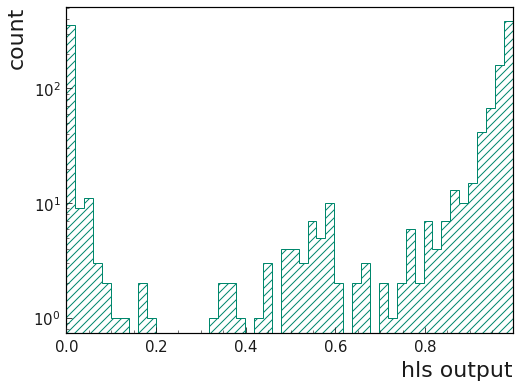

In [8]:
import matplotlib.pyplot as plt
plt.style.use('kit_hist')
plt.hist(hls_output, facecolor=(0,0,0,0), histtype='stepfilled', bins=50)
plt.yscale('log')
plt.xlabel('hls output')
plt.ylabel('count')
plt.show()

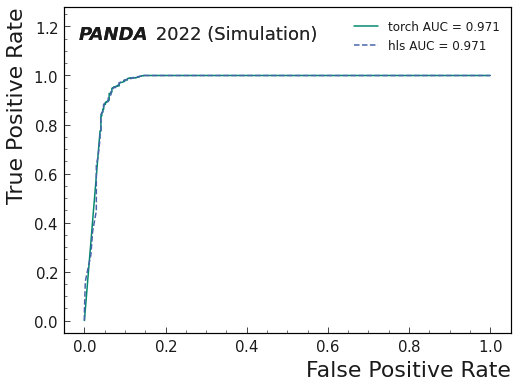

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from utils.plotting.plot import watermark

torch_roc = all_torch_error['ROC']
hls_roc = all_hls_error['ROC']

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
    watermark(py=0.9, shift=0.16, scale=1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.91), fontsize=12)

plt.figure(figsize=(8,6))
plot_roc(torch_roc, 'torch')    
plot_roc(hls_roc, 'hls')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()



# Compare for different floating point sizes

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  


bits = [8,12,16,20,24]
rocs=[]

for b in tqdm(bits):
    precision = f'ap_fixed<{b},{int(b/2)}>'
    model_dir = 'models/trained_IN_neurons_8.pt'
    output_dir = f"hls_output/precision_{b}"
    index_precision = 'ap_uint<8>'
    reuse = 1
    part = 'xcvu9p-flga2104-2L-e'

    torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,graph_dims, hls_only=False)
    hls_model.compile()
    all_torch_error, all_hls_error, all_torch_hls_diff, _, _ = compare_hls4ml(graphs, output_dir, torch_model, hls_model, torch_wrapper, all_metrics=True)
    hls_roc = all_hls_error['ROC'] 
    rocs.append(hls_roc)

In [ ]:
def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
plot_roc(torch_roc, 'torch') 
for i,b in enumerate(bits):
    
    plot_roc(rocs[i], f'hls {b} bit')

watermark(py=0.9, shift=0.16, scale=1.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'trained on {nevents} events')
plt.legend(loc='lower right', fontsize=12, frameon = True, framealpha = 0.7, facecolor = 'white', edgecolor = 'white')
plt.savefig(f'img/hls_roc_plot_ngraphs_{nevents}.png', bbox_inches='tight')
plt.show()

# Build HLS
This is not the compilation output of this script but of another one from the given directory

In [ ]:
import hls4ml
hls4ml.report.read_vivado_report('hls_output/test/')

# Test dummy data inference

for simple comparison with Vivado network inference simulation

In [ ]:
import torch
import numpy as np

data = graphs[11]

data.x = torch.zeros(data.x.shape)
data.edge_attr = torch.zeros(data.edge_attr.shape)
test = np.arange(0,data.edge_index.shape[1])

data.edge_index = torch.tensor((test, 37-test), dtype=torch.long) % data.x.shape[0]


torch_pred = torch_model(data).detach().cpu().numpy()

In [ ]:
print(data.edge_index)

In [ ]:
plt.plot(torch_pred)